# Krypton Lifetime

## Produce lifetime map 

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Sat Aug 25 16:50:37 2018


### Input files

In [3]:
from krcal.core.kr_types import KrFileName

input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"


input_file_names  = ['dst_6284_trigger1_0000_7920.h5']

output_file_name  = ' '
map_file_name     = 'kr_maps_6284.h5'
map_file_name_ts  = 'kr_maps_ts_6284.h5'
emap_file_name    = ''

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [5]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts

In [8]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [9]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [10]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [11]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [12]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [236]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import rphi_sector_equal_area_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import draw_map
from krcal.core.map_functions   import draw_maps_ts

In [14]:
import krcal.dev.corrections       as corrections 


In [15]:
from numpy import pi

In [16]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [17]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [18]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [19]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6284_trigger1_0000_7920.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_6284.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_ts_6284.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/')

In [20]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [21]:
#unique_events = ~dst.event.duplicated()
#number_of_evts_full = np.count_nonzero(unique_events)

# Above does not work when glueing multiple DSTs, events ARE duplicated,
# since event number starts at 0, rather than taking true event number. 

print(f"Total number of events: {len(dst)}")

Total number of events: 1583342


In [22]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [23]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [24]:
DT

array([0.00000000e+00, 2.80001163e-02, 1.34999990e-01, ...,
       8.68801010e+04, 8.68802880e+04, 8.68804980e+04])

### Ranges and binning

In [25]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [26]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

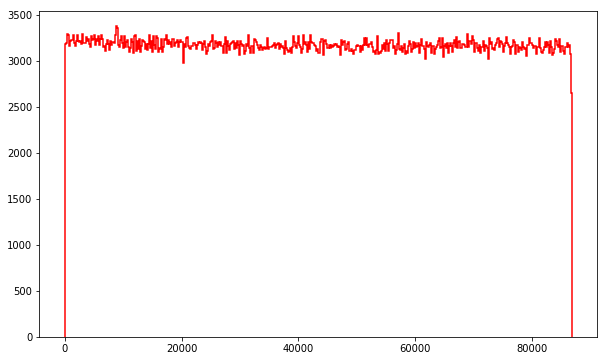

In [27]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

## Divide chamber in sector of R and Phi

In [210]:
RMIN       = 18
RMAX       =180
NSECTORS   =10   # number of radial sectors, thus sector size RMAX/NSECTORS
SPHI       =10  # size of the wedge in degrees

R, PHI = rphi_sector_map(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [158]:
#R, PHI =  rphi_sector_equal_area_map(rmin =  18, rmax = 180, sphi=SPHI)

nSectors = 100


In [159]:
NSECTORS = len(R.keys())

In [211]:
W = define_rphi_sectors(R, PHI, verbose=False)

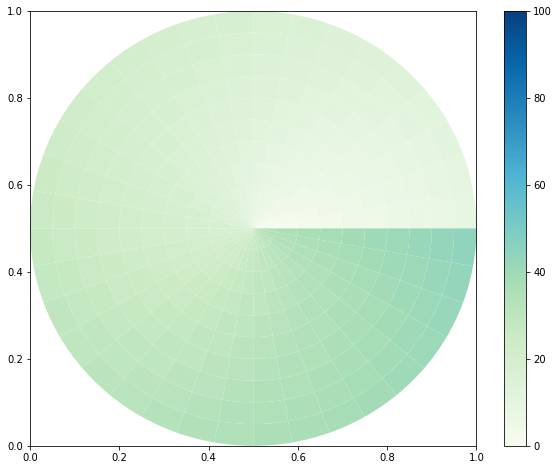

In [212]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [213]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W, verbose = True)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 calling selection_mask
 sector = 0
 sector = 1
 sector = 2
 sector = 3
 sector = 4
 sector = 5
 sector = 6
 sector = 7
 sector = 8
 sector = 9
 selection_mask computed, filling RGES
 defining kr_event for sector 0
 defining kr_event for sector 1
 defining kr_event for sector 2
 defining kr_event for sector 3
 defining kr_event for sector 4
 defining kr_event for sector 5
 defining kr_event for sector 6
 defining kr_event for sector 7
 defining kr_event for sector 8
 defining kr_event for sector 9
 RGES computed
 KRES: t = 11.479087114334106


### Time 

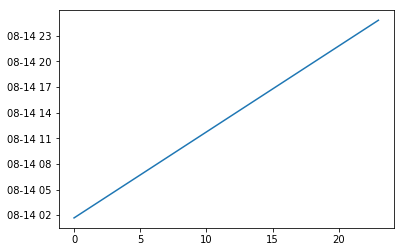

In [32]:
plt.plot(krTimes.timeStamps)

### Event distribution

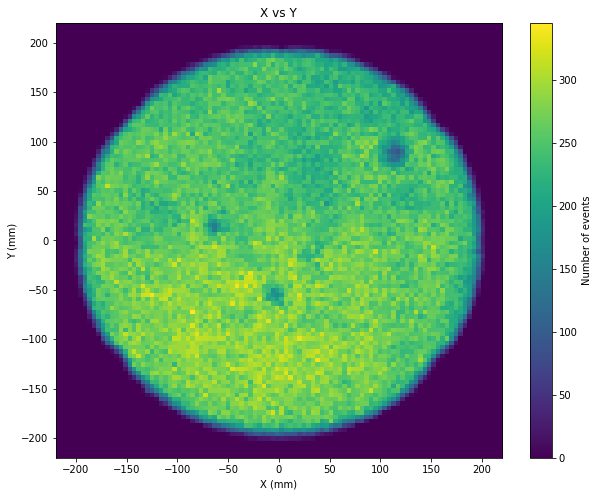

In [33]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Events per sector

number of events in sector = 67476.0


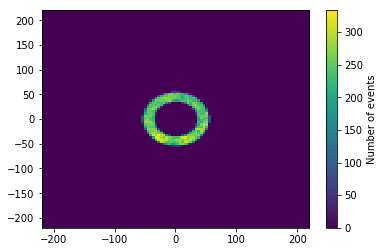

In [214]:
plot_sector(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, sector=2)

In [164]:
#plot_sectors(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, nx = 10, ny = 10,figsize=(14,14))

## Fits in radial sectors

### Lifetime is fitted each XT seconds in the radial sectors (0 to 9) defined.

In [146]:
DT[-1] /20000

4.344024899995327

In [147]:
XT = 20000

In [237]:
fps = fit_fcs_in_sectors(0, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12500),
                         energy = 'S2e', fit = FitType.unbined)
                    

wedge = 0: chi2 =     1.38 ; e0 = 11976.64 +-  71.68; lt =  2315.32 +-  66.80;
wedge = 1: chi2 =     1.27 ; e0 = 11977.01 +-  13.05; lt =  2314.67 +-  33.88;
wedge = 2: chi2 =     0.90 ; e0 = 12037.79 +-  57.93; lt =  2271.15 +-  99.91;
wedge = 3: chi2 =     1.02 ; e0 = 12004.72 +-  52.68; lt =  2320.44 +-  80.10;
wedge = 4: chi2 =     0.88 ; e0 = 12040.80 +-  26.82; lt =  2281.93 +-  39.11;
wedge = 5: chi2 =     1.20 ; e0 = 12017.97 +-   6.41; lt =  2299.03 +-  10.65;
wedge = 6: chi2 =     1.16 ; e0 = 12077.71 +-  81.98; lt =  2248.22 +-  89.02;
wedge = 7: chi2 =     1.23 ; e0 = 12026.61 +-  44.68; lt =  2306.27 +-  70.25;
wedge = 8: chi2 =     1.05 ; e0 = 11965.66 +-  18.74; lt =  2349.12 +-  22.74;
wedge = 9: chi2 =     1.04 ; e0 = 11955.07 +-  65.57; lt =  2396.91 +-  87.68;
wedge = 10: chi2 =     1.22 ; e0 = 11936.57 +-  19.49; lt =  2372.97 +-  58.90;
wedge = 11: chi2 =     1.19 ; e0 = 12046.95 +-  19.95; lt =  2238.55 +-  28.16;
wedge = 12: chi2 =     1.05 ; e0 = 12016.20 +-  30

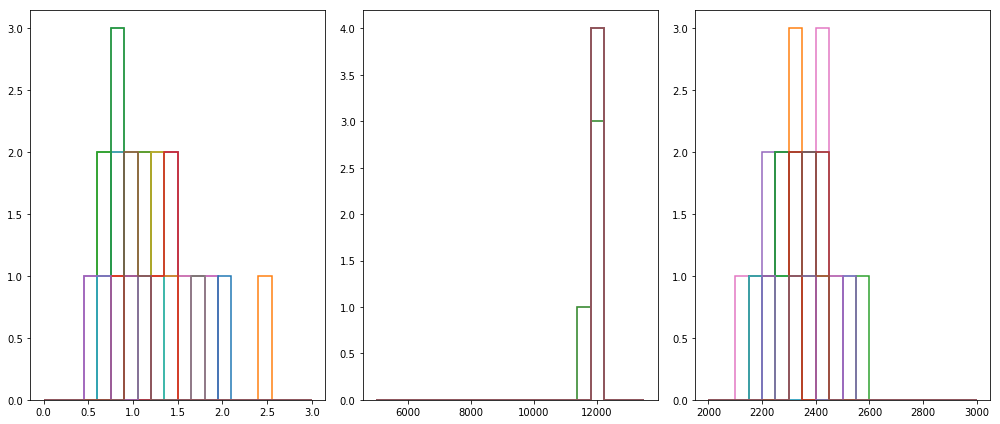

In [238]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,13500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

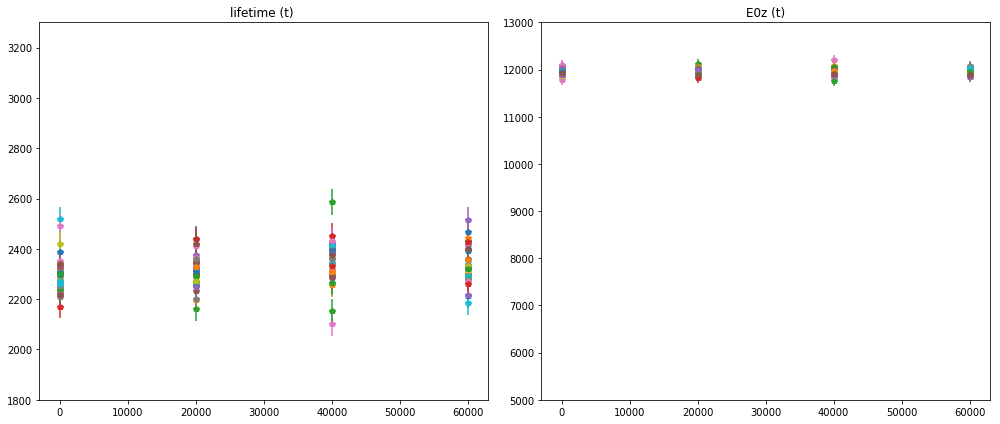

In [239]:
plot_fit_sectors(fps,  range_e0 =(5000,13000), range_lt=(1800, 3300))

In [240]:
fps = fit_fcs_in_sectors(1, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
 

wedge = 0: chi2 =     0.66 ; e0 = 11927.82 +-  28.90; lt =  2323.57 +-  24.41;
wedge = 1: chi2 =     0.79 ; e0 = 12000.87 +-  44.95; lt =  2222.47 +-  45.19;
wedge = 2: chi2 =     0.77 ; e0 = 11887.13 +-  36.17; lt =  2351.34 +-  59.13;
wedge = 3: chi2 =     0.69 ; e0 = 11885.00 +-  12.17; lt =  2375.35 +-  22.37;
wedge = 4: chi2 =     0.92 ; e0 = 11933.68 +-  25.44; lt =  2386.11 +-  30.09;
wedge = 5: chi2 =     0.84 ; e0 = 12032.31 +-  21.81; lt =  2326.13 +-  42.35;
wedge = 6: chi2 =     0.81 ; e0 = 12043.21 +-  27.77; lt =  2309.78 +-  41.25;
wedge = 7: chi2 =     0.97 ; e0 = 12059.47 +-  27.93; lt =  2269.06 +-  19.41;
wedge = 8: chi2 =     0.91 ; e0 = 12009.42 +-  41.47; lt =  2317.93 +-  54.81;
wedge = 9: chi2 =     0.99 ; e0 = 11971.75 +-  24.80; lt =  2340.45 +-  48.54;
wedge = 10: chi2 =     0.86 ; e0 = 11972.13 +-  28.58; lt =  2339.49 +-  61.90;
wedge = 11: chi2 =     0.80 ; e0 = 12014.74 +-  12.96; lt =  2253.10 +-  40.61;
wedge = 12: chi2 =     1.03 ; e0 = 11972.90 +-  28

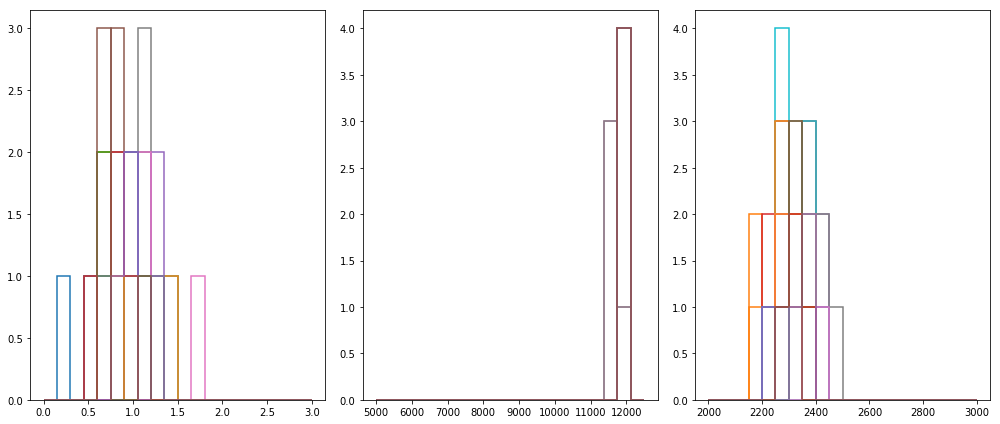

In [241]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts )

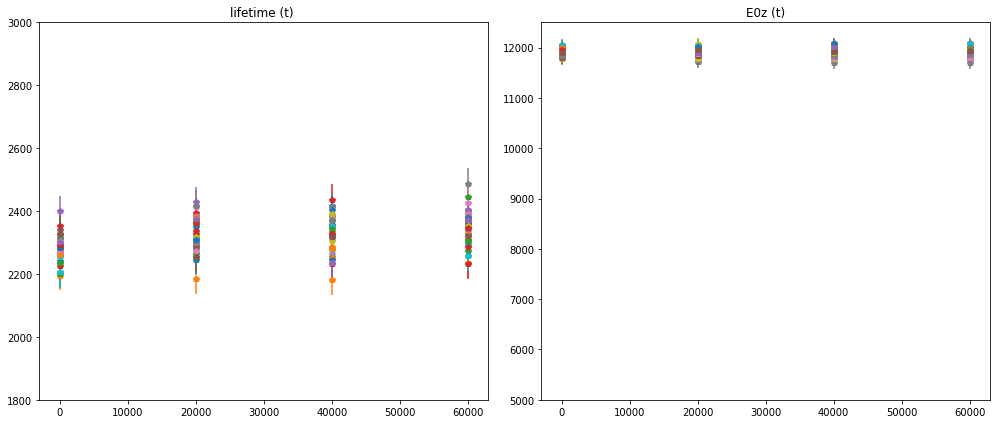

In [242]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [243]:
fps = fit_fcs_in_sectors(2, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)



wedge = 0: chi2 =     0.83 ; e0 = 11944.33 +-  25.91; lt =  2327.98 +-  45.42;
wedge = 1: chi2 =     0.90 ; e0 = 11923.65 +-  24.14; lt =  2339.13 +-  42.90;
wedge = 2: chi2 =     0.87 ; e0 = 11937.30 +-   8.50; lt =  2415.79 +-  23.27;
wedge = 3: chi2 =     0.95 ; e0 = 12096.65 +-  54.07; lt =  2333.66 +-  54.82;
wedge = 4: chi2 =     0.75 ; e0 = 12311.68 +-  15.31; lt =  2221.74 +-  23.94;
wedge = 5: chi2 =     0.91 ; e0 = 12383.34 +-  21.31; lt =  2212.50 +-  17.61;
wedge = 6: chi2 =     0.88 ; e0 = 12250.49 +-  26.51; lt =  2277.75 +-  40.71;
wedge = 7: chi2 =     0.99 ; e0 = 12078.48 +-  19.85; lt =  2311.13 +-  50.49;
wedge = 8: chi2 =     0.78 ; e0 = 11968.33 +-  21.75; lt =  2310.50 +-  43.44;
wedge = 9: chi2 =     1.00 ; e0 = 11947.54 +-  11.02; lt =  2278.84 +-  33.84;
wedge = 10: chi2 =     0.79 ; e0 = 11956.51 +-  22.18; lt =  2282.57 +-  36.61;
wedge = 11: chi2 =     1.00 ; e0 = 11931.73 +-  23.32; lt =  2286.27 +-  27.74;
wedge = 12: chi2 =     0.87 ; e0 = 11819.87 +-  29

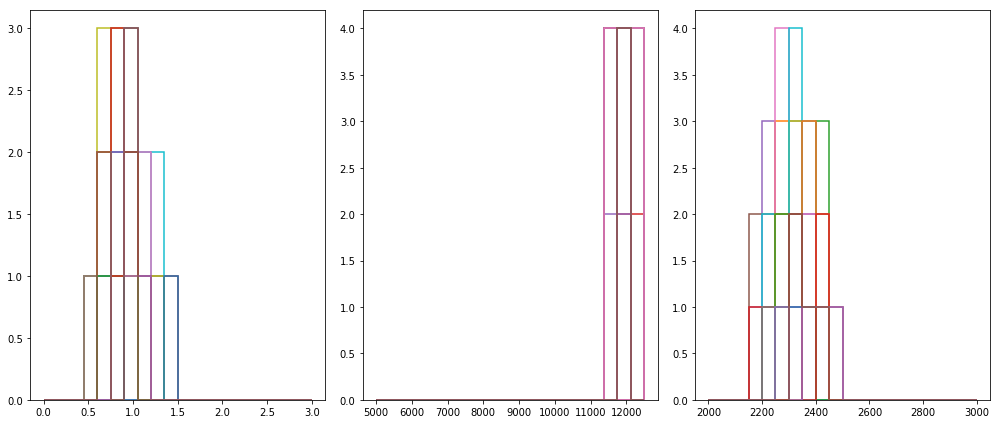

In [244]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

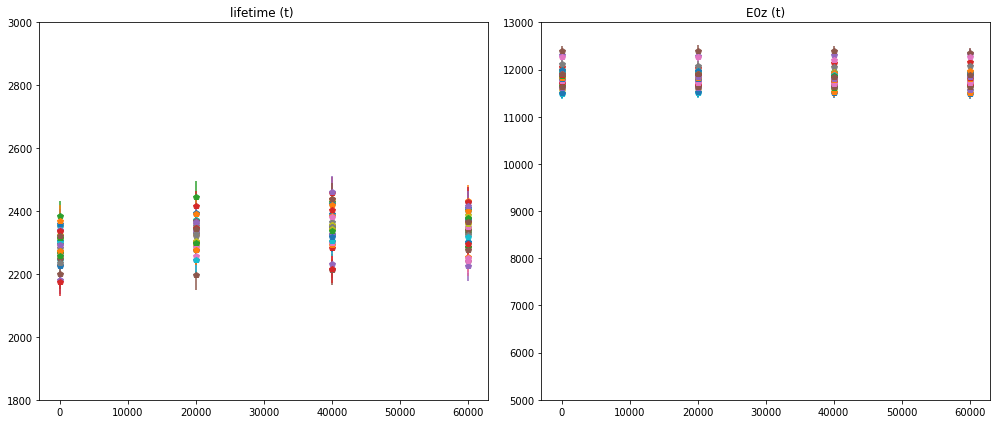

In [245]:
plot_fit_sectors(fps,  range_e0 =(5000,13000), range_lt=(1800, 3000))

In [246]:
fps = fit_fcs_in_sectors(8, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.86 ; e0 = 10682.95 +-  16.80; lt =  2287.65 +-  35.24;
wedge = 1: chi2 =     1.23 ; e0 = 10786.85 +-   4.23; lt =  2321.68 +-  27.90;
wedge = 2: chi2 =     0.89 ; e0 = 11023.13 +-  13.70; lt =  2270.22 +-  38.45;
wedge = 3: chi2 =     0.88 ; e0 = 11093.07 +-  14.09; lt =  2268.02 +-  24.13;
wedge = 4: chi2 =     0.76 ; e0 = 11130.81 +-  22.97; lt =  2272.96 +-  55.80;
wedge = 5: chi2 =     0.94 ; e0 = 10953.89 +-   9.82; lt =  2306.75 +-  23.57;
wedge = 6: chi2 =     0.83 ; e0 = 10903.94 +-  17.92; lt =  2280.17 +-  40.97;
wedge = 7: chi2 =     0.96 ; e0 = 10950.59 +-  12.93; lt =  2280.25 +-  23.64;
wedge = 8: chi2 =     0.64 ; e0 = 10804.55 +-   7.90; lt =  2251.13 +-  24.05;
wedge = 9: chi2 =     0.80 ; e0 = 10587.08 +-  20.01; lt =  2245.69 +-  27.36;
wedge = 10: chi2 =     1.18 ; e0 = 10482.84 +-   9.05; lt =  2238.58 +-  25.56;
wedge = 11: chi2 =     0.96 ; e0 = 10366.37 +-  10.54; lt =  2247.19 +-  18.78;
wedge = 12: chi2 =     1.02 ; e0 = 10170.22 +-  11

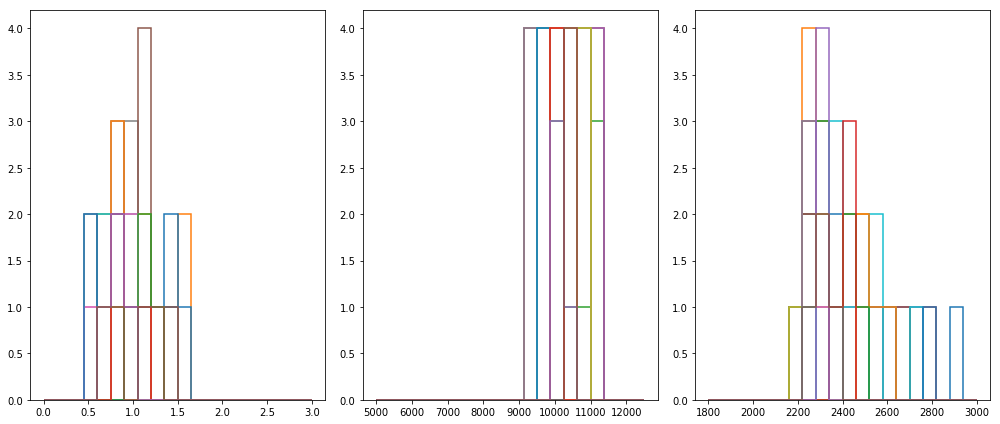

In [247]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

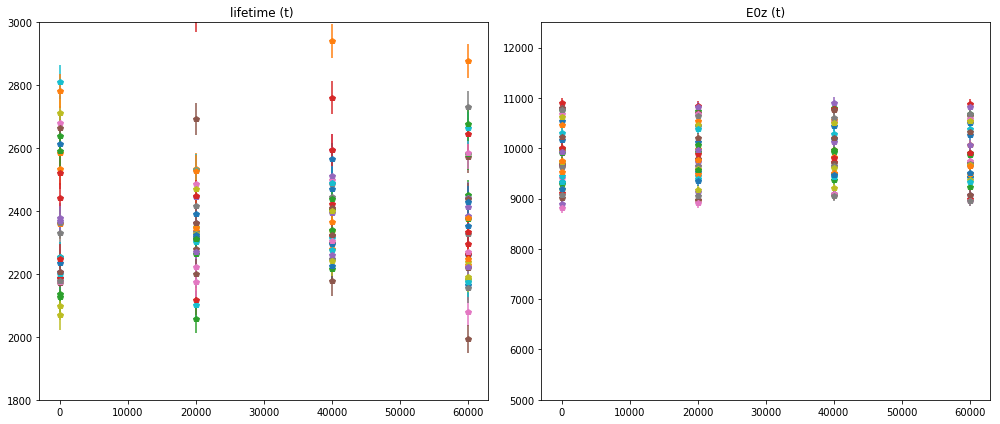

In [206]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [248]:
fps = fit_fcs_in_sectors(9, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.64 ; e0 = 10198.58 +-  18.28; lt =  2199.52 +-  49.86;
wedge = 1: chi2 =     0.96 ; e0 = 10157.24 +-   8.13; lt =  2263.53 +-  24.53;
wedge = 2: chi2 =     0.77 ; e0 = 10310.67 +-  22.48; lt =  2268.26 +-  59.97;
wedge = 3: chi2 =     0.88 ; e0 = 10465.43 +-  10.52; lt =  2219.58 +-  29.67;
wedge = 4: chi2 =     1.09 ; e0 = 10456.92 +-   4.86; lt =  2248.92 +-  28.91;
wedge = 5: chi2 =     0.95 ; e0 = 10447.97 +-   4.28; lt =  2225.58 +-  19.34;
wedge = 6: chi2 =     1.16 ; e0 = 10269.58 +-  11.09; lt =  2236.78 +-  25.67;
wedge = 7: chi2 =     0.90 ; e0 = 10356.29 +-  10.20; lt =  2195.31 +-  25.20;
wedge = 8: chi2 =     0.97 ; e0 = 10171.15 +-   6.75; lt =  2173.93 +-  12.88;
wedge = 9: chi2 =     0.99 ; e0 =  9898.90 +-  16.27; lt =  2199.01 +-  29.19;
wedge = 10: chi2 =     1.08 ; e0 =  9770.32 +-   6.28; lt =  2191.92 +-   5.33;
wedge = 11: chi2 =     0.74 ; e0 =  9654.75 +-   7.67; lt =  2223.58 +-  34.89;
wedge = 12: chi2 =     0.88 ; e0 =  9592.86 +-   9

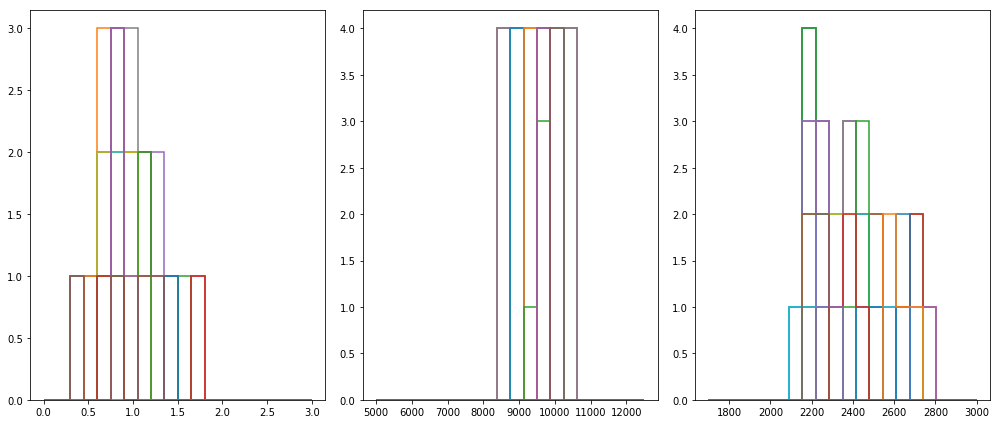

In [249]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1700, 3000))
print_fit_sectors_pars(fpts)

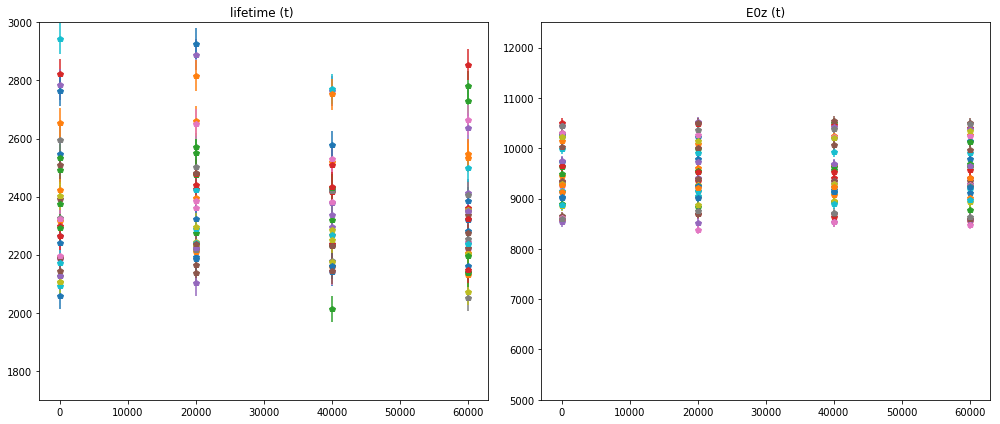

In [209]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1700, 3000))

### Fits in sectors:
1. chi2 of fits is good.
2. E0 decreases in each sector and varies significantly with phi.
3. LT has an structure, splitting in some sectors in two peaks.

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```
Thus, for each radial sector (0, 1, 2...) the function returns a list of objects, one object per phi sector (or wedge). Each object contains 6 time series; ts is time (time difference wrt to the start of the run); e0, lt... are fitted parameters to time slices.

In [218]:
fmap = fit_map(XT, DT, KRES, 
               krNbins.Z, krNbins.S2e,
               range_z     = (50,550),
               range_e     = (5000, 13000),
               range_chi2  = (0,3),
               range_lt    = (1700, 3300),
               energy      = 'S2e', 
               fit         = FitType.profile,
               verbose     = True)

Fitting sector 0
 number of wedges in sector 36
Fitting sector 1
 number of wedges in sector 36
Fitting sector 2
 number of wedges in sector 36
Fitting sector 3
 number of wedges in sector 36
Fitting sector 4
 number of wedges in sector 36
Fitting sector 5
 number of wedges in sector 36
Fitting sector 6
 number of wedges in sector 36
Fitting sector 7
 number of wedges in sector 36
Fitting sector 8
 number of wedges in sector 36
Fitting sector 9
 number of wedges in sector 36


In [172]:
ts = fmap[0][0].ts

In [173]:
ts

array([    0, 20000, 40000, 60000])

In [72]:
DT

array([0.00000000e+00, 2.80001163e-02, 1.34999990e-01, ...,
       8.68801010e+04, 8.68802880e+04, 8.68804980e+04])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [219]:
tsm = tsmap_from_fmap(fmap, verbose  = False)

<ErrorbarContainer object of 3 artists>

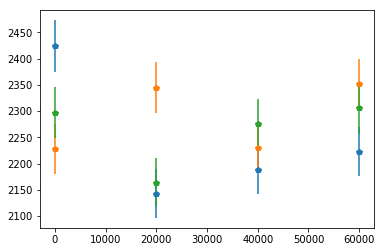

In [220]:
plt.errorbar(ts, tsm.lt[0][0], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[0][1], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[0][2], np.sqrt(tsm.lt[0][2]), fmt="p")

<ErrorbarContainer object of 3 artists>

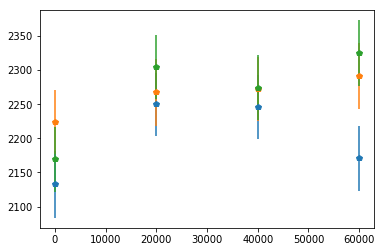

In [221]:
plt.errorbar(ts, tsm.lt[9][0], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[9][1], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[9][2], np.sqrt(tsm.lt[0][2]), fmt="p")

#### Obtain ampa from tsm: The object returned is ASectorMap
```
@dataclass
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : DataFrame
    e0    : DataFrame
    lt    : DataFrame
    e0u   : DataFrame
    ltu   : DataFrame

```
In this ASectorMap each wege contains a single number, and thus ASectorMap is really a 
collection of 5 maps. 

#### The map that averages the time series is obtained by setting ts = -1 

In [222]:
am = amap_from_tsmap(tsm, 
                     ts = -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))

In [223]:
asm = relative_errors(am)

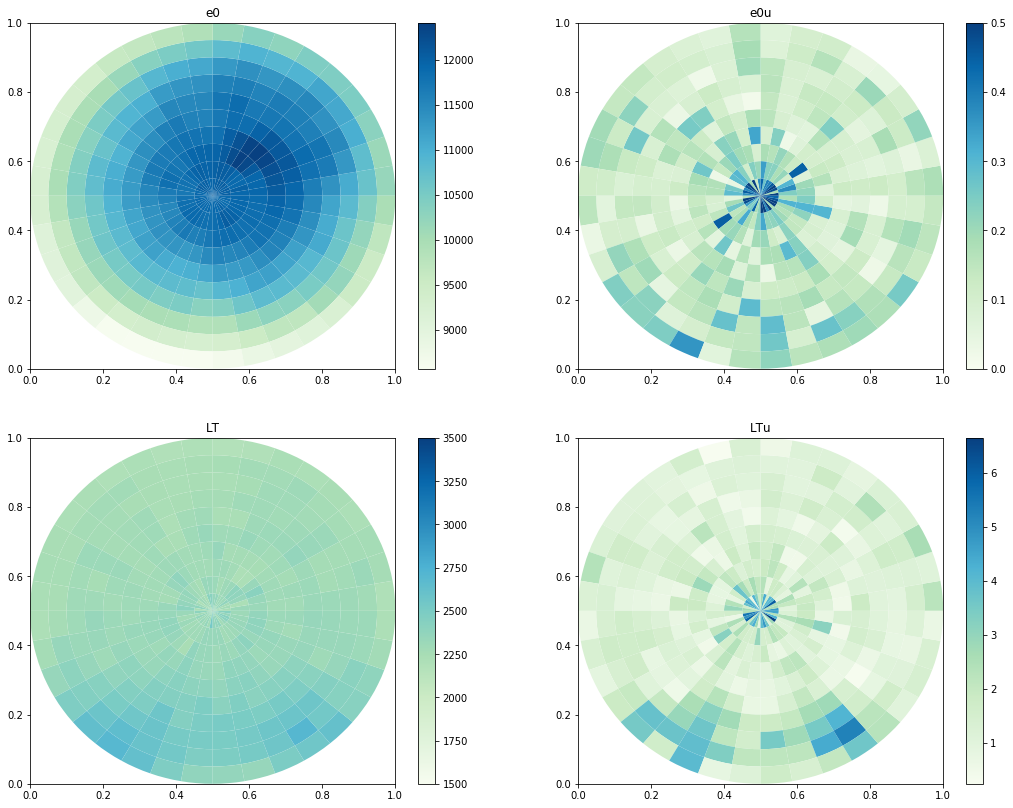

In [224]:
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3500),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

### One can draw a specific map

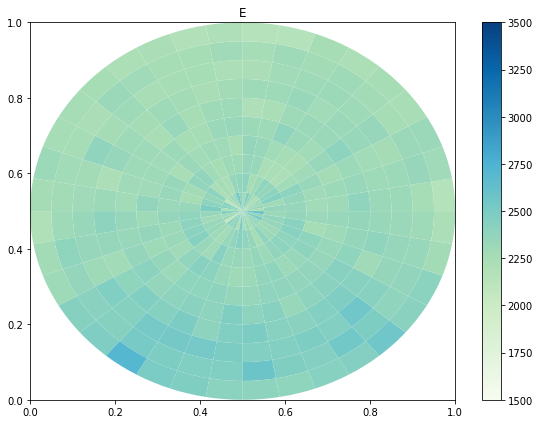

In [252]:
draw_map(W, aMap = asm.lt,  
         alims    = (1500, 3500),
         cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
         alpha   = 1.0,  
         figsize=(8,6))

#### The maps can be saved to file

In [226]:
write_maps(asm, filename=fn.map_file_name)

#### And retrieved from file

In [227]:
me0df, me0udf, mltdf, mltudf = read_maps(filename=fn.map_file_name)

#### To produce a map for a given point in the same series one uses ts = 0, 1... len(ts)

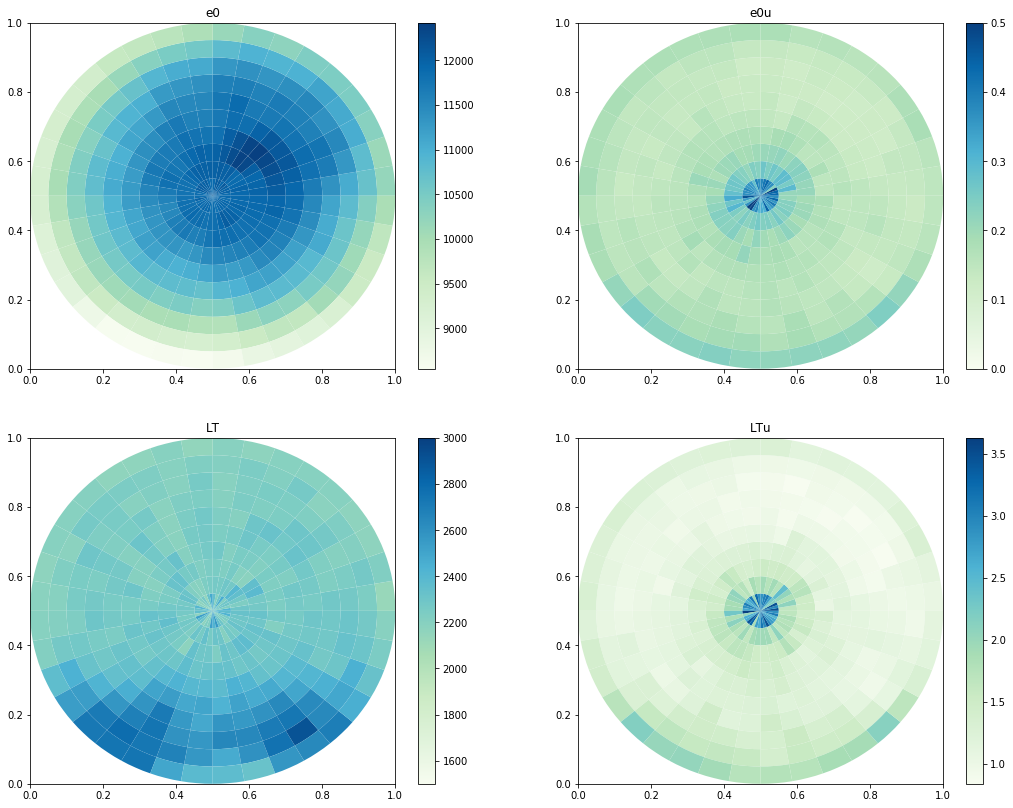

In [228]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

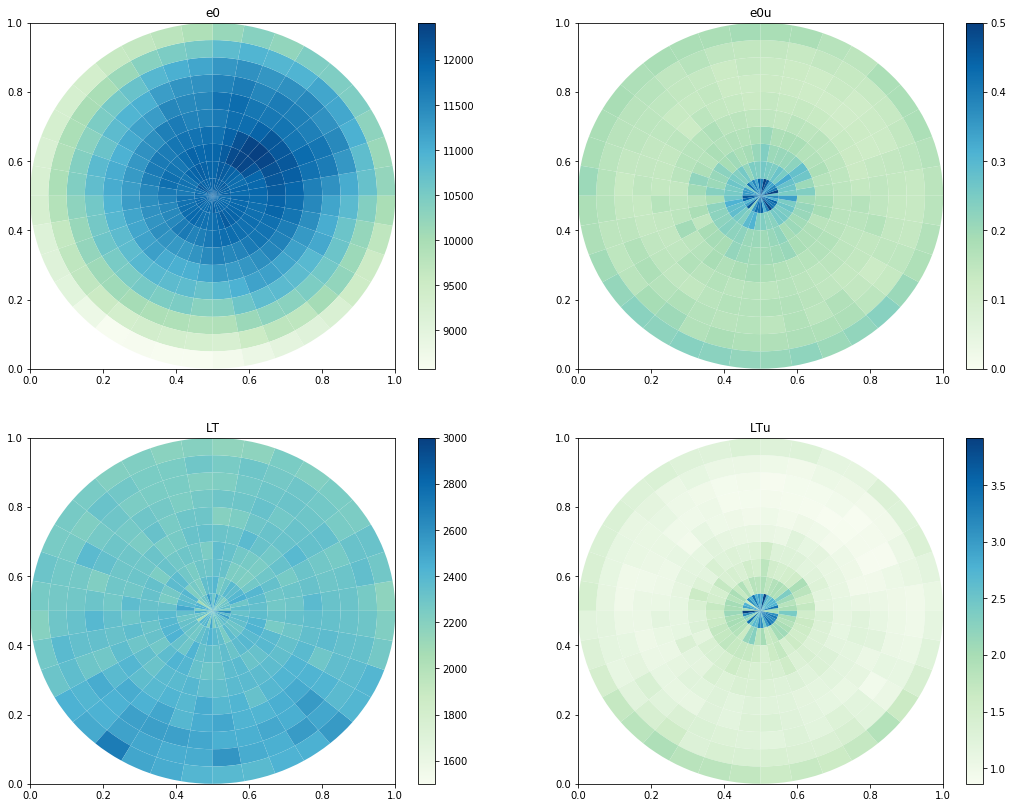

In [229]:
am = amap_from_tsmap(tsm, 
                     ts = len(ts) -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

#### Full map series:

In [230]:
aMaps = []
draw = False
for i, _ in enumerate(ts):
    am = amap_from_tsmap(tsm, 
                         ts = i, 
                         range_e     = (5000, 13000),
                         range_chi2  = (0,3),
                         range_lt    = (1700, 3700))
    asm = relative_errors(am)
    aMaps.append(am)
    if draw:
        draw_maps(W, asm,  
                  e0lims  = None,
                  ltlims  = (1500, 3000),
                  eulims  = (0, 0.5),
                  lulims  = None,
                  cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
                  alpha   = 1.0,  
                  figsize=(18,14))

#### To write the complete time-series of maps
```
write_maps_ts(aMaps : Iterable[ASectorMap], ts: np.array, filename : str)
```

In [233]:
write_maps_ts(aMaps, ts, filename=fn.map_file_name_ts)

### One can draw also the LT maps for the different time sectors.

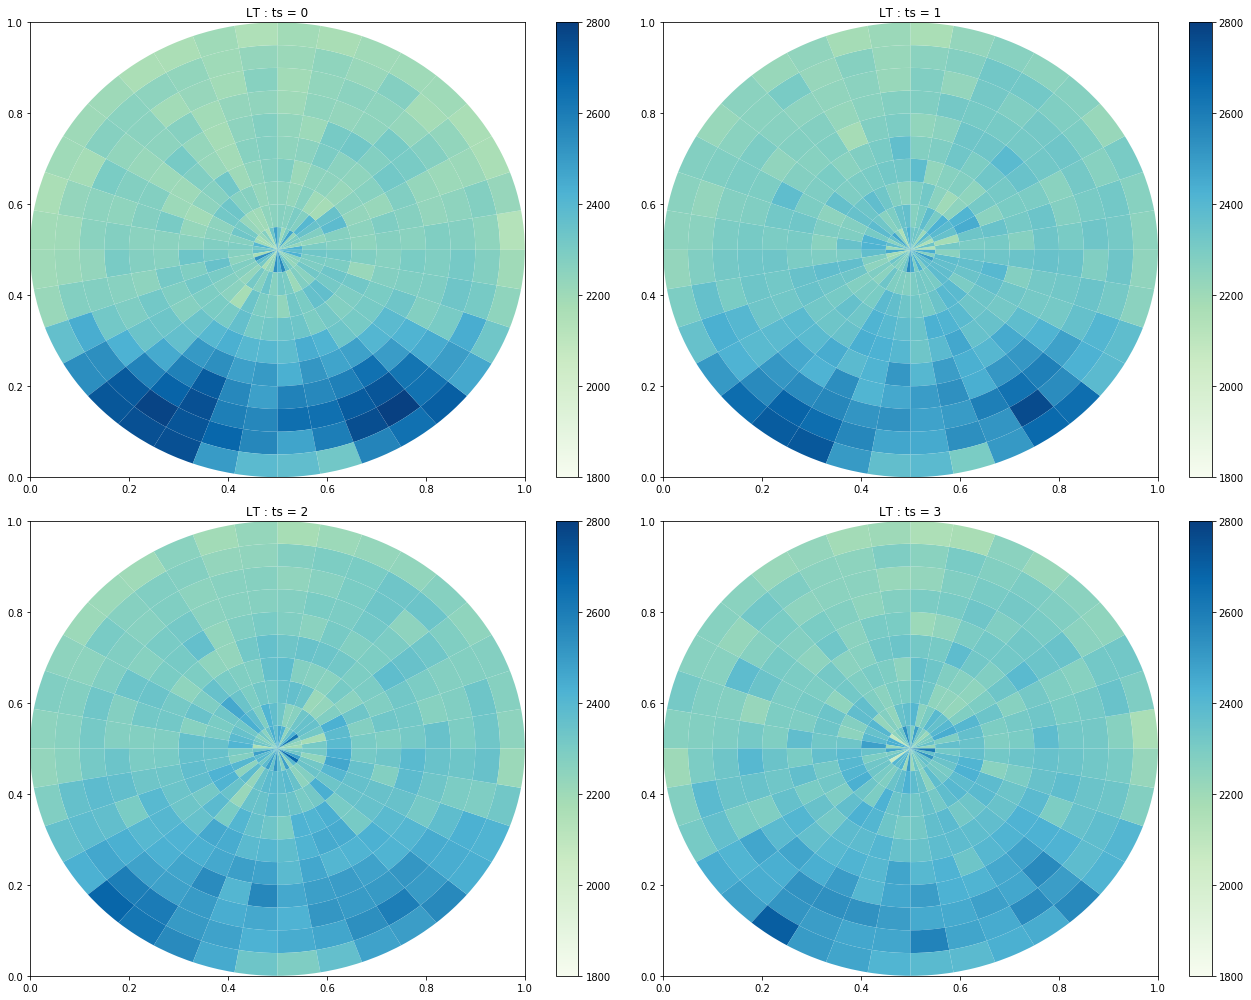

In [253]:
draw_maps_ts(W, aMaps,  
             wmap   = MapType.LT,
             ltlims = (1800, 2800),
             cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
             alpha   = 1.0,  
             figsize=(18,14))

### And energy maps

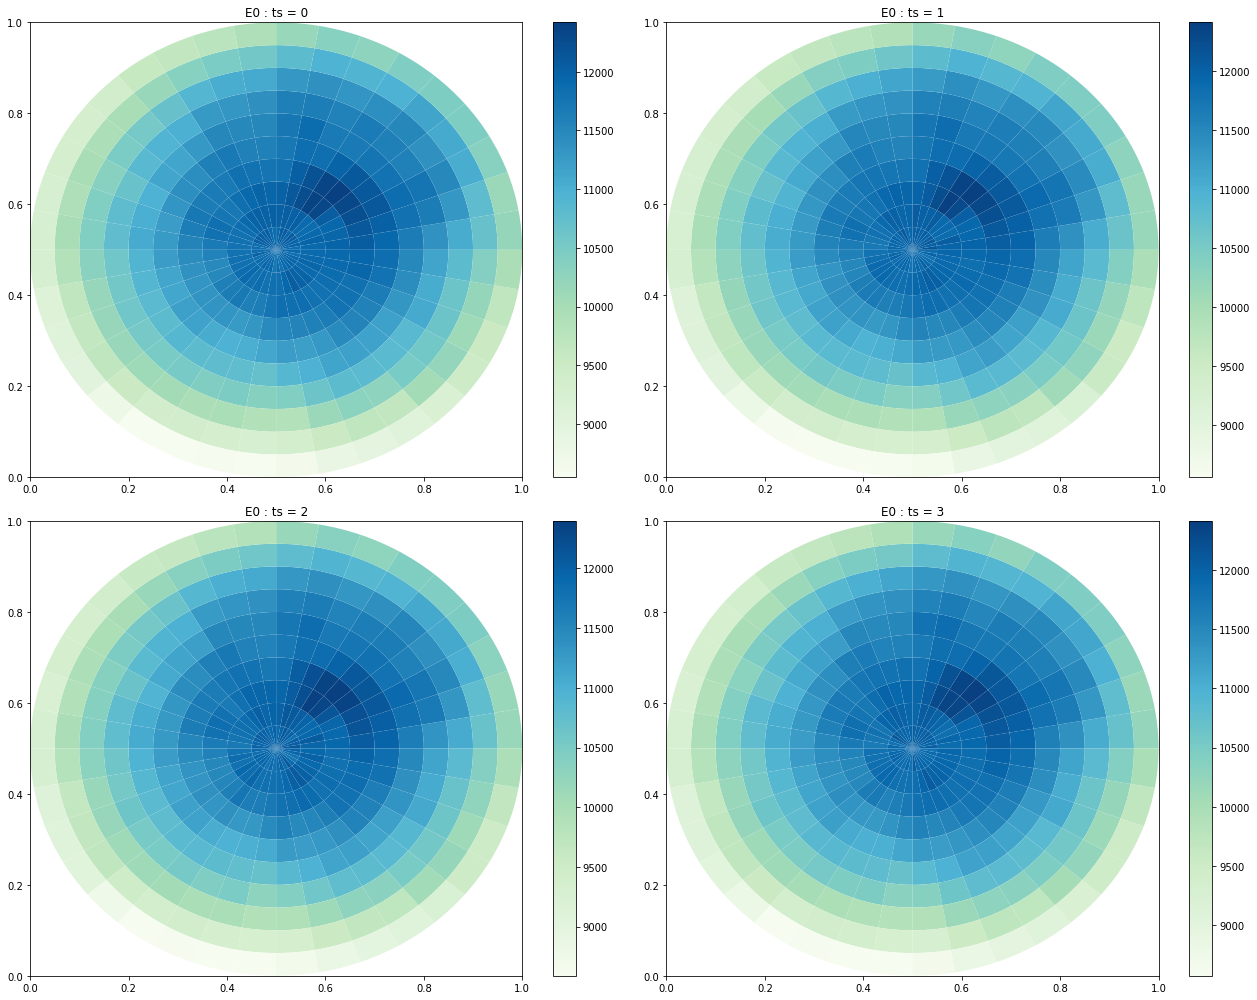

In [255]:
draw_maps_ts(W, aMaps,  
             wmap   = MapType.E0,
             cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
             alpha   = 1.0,  
             figsize=(18,14))